<a href="https://colab.research.google.com/github/dishadtu/working_GAN_MNIST/blob/main/working_GAN_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# https://spotintelligence.com/2023/03/08/generative-adversarial-network-gan/
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Generator model
def make_generator_model():
    model = keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

# Discriminator model
def make_discriminator_model():
    model = keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [3]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [4]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

11490434/11490434 [==============================] - 0s 0us/step
Epoch 1 completed
Epoch 2 completed
Epoch 3 completed
Epoch 4 completed
Epoch 5 completed
Epoch 6 completed
Epoch 7 completed
Epoch 8 completed
Epoch 9 completed


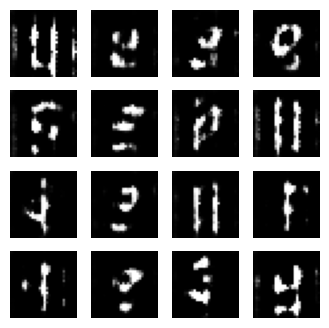

Epoch 10 completed
Epoch 11 completed
Epoch 12 completed
Epoch 13 completed
Epoch 14 completed
Epoch 15 completed
Epoch 16 completed
Epoch 17 completed
Epoch 18 completed
Epoch 19 completed


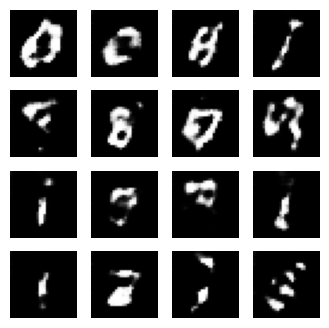

Epoch 20 completed
Epoch 21 completed


In [ ]:
# Load the MNIST dataset
(train_images, train_labels), (_, _) = keras.datasets.mnist.load_data()
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]

# Set the batch size and number of epochs
BUFFER_SIZE = 60000
BATCH_SIZE = 256
EPOCHS = 100

# Create the generator
generator = make_generator_model()

# Create the discriminator
discriminator = make_discriminator_model()

#Define the training loop
@tf.function
def train_step(images):
  # Generate random noise
  noise = tf.random.normal([BATCH_SIZE, 100])
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      # Generate images using the generator
      generated_images = generator(noise, training=True)
  
      # Get the discriminator's predictions for the real and generated images
      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)
  
      # Calculate the loss for both the generator and discriminator
      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

  # Calculate the gradients for the generator and discriminator
  gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
  gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
  
  # Apply the gradients to the optimizer
  generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

# Create a function to generate and save images
def generate_and_save_images(model, epoch, test_input):
  # Generate images from the model
  predictions = model(test_input, training=False)
  # Rescale the pixel values to [0, 1]
  predictions = (predictions + 1) / 2.0
  
  # Create a plot to display the images
  fig = plt.figure(figsize=(4, 4))
  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0], cmap='gray')
      plt.axis('off')
  
  # Save the plot
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()
  
# Create a function to train the GAN
def train(dataset, epochs):
  # Generate a fixed noise vector to use for visualization
  test_input = tf.random.normal([16, 100])
  for epoch in range(epochs):
    for image_batch in dataset:
        # Train the discriminator
        train_step(image_batch)

    # Generate and save images every 10 epochs
    if (epoch + 1) % 10 == 0:
        generate_and_save_images(generator, epoch + 1, test_input)

    print('Epoch {} completed'.format(epoch + 1))

  # Generate a final set of images and save them
  generate_and_save_images(generator, epochs, test_input)
  
# Load the dataset and create batches
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# Train the GAN
train(train_dataset, EPOCHS)